In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

import os
import glob
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report

!pip install autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

In [ ]:
# Check for GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

# Load Dataset

Load `.csv` files, concatenate them into one dataset and count rows and columns

In [ ]:
!wget 'https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/data/dataset/datasets.zip'

!unzip datasets.zip

In [3]:
# Create full dataframe with all subject csv's concatenated
path = r'content/output/'
all_files = glob.glob(path + '/*.csv')

li = []
acc_rows = 0

for filename in all_files:
    subject_csv = pd.read_csv(filename, index_col=False)
    acc_rows += len(subject_csv.axes[0])

    li.append(subject_csv)

df = pd.concat(li, axis=0, ignore_index=True)


# Rows and Columns
total_rows = len(df.axes[0])
total_cols = len(df.axes[1])
print('Number of Rows: ', total_rows)
print('Number of Columns: ', total_cols)

assert total_rows == acc_rows, 'Number of rows does not match'

df

Number of Rows:  772295
Number of Columns:  6


,Time,X,Y,Z,Heart Rate,Labels
0,1.0,0.173477,0.037720,0.987289,71.0,0.0
1,2.0,0.181351,0.042587,0.990738,71.0,0.0
2,3.0,0.199982,0.039688,1.020813,71.0,0.0
3,4.0,0.199005,0.026444,1.004486,71.0,0.0
4,5.0,0.198181,0.022995,0.984344,71.0,0.0
...,...,...,...,...,...,...
772290,28435.0,0.314224,0.354416,0.879440,74.0,-1.0
772291,28436.0,0.314682,0.353943,0.879440,74.0,-1.0
772292,28437.0,0.314728,0.354904,0.878937,74.0,-1.0
772293,28438.0,0.314713,0.354919,0.878967,74.0,-1.0


# Preparing the data

Removing `Time` column, since a strict time series approach did not yield the best results. More information in the [Model used for this project](README.md#Model-used-for-this-project) section.

In [ ]:
df = df.drop('Time', axis=1)

Preparing labels

* Initial stages (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)

* Relabeled stages (0-4, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 4)

In [ ]:
# Delete non-labeled Rows
df.dropna(inplace=True)

df['Labels'] = df['Labels'].astype(int)

df = df.drop(df.index[(df.Labels < 0) | (df.Labels == 4)])

# Same labels will be reused throughout the program
df['Labels'] = df['Labels'].map({0:0,1:1,2:2,3:3,5:4,}, na_action=None)

## EDA

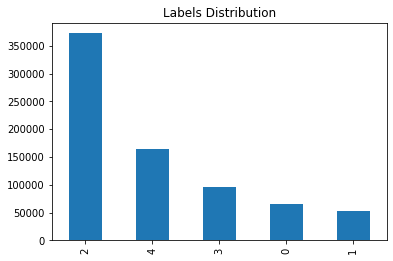

In [ ]:
# Labels Distribution
df['Labels'].value_counts().plot(kind='bar', title ='Labels Distribution')

## Balancing the dataset
Based on the unbalanced distribution of the dataset, let's even it out by applying undersampling (i.e. reducing the number of samples of all of the biggest classes down to the size of the smallest one). 

In the case the resulting dataset is too small, a more advanced approach of combining undersampling and oversampling might be taken. This approach would take a class with the closest size to the average size as a reference threshold, undersample the bigger classes and oversample the smaller ones. this would guarantee a bigger perfectly balanced dataset.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


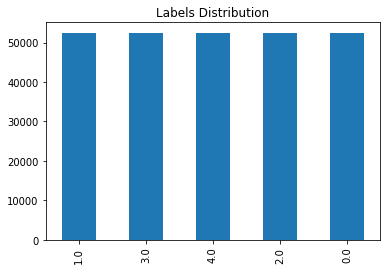

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_under, y_under = under_sampler.fit_resample(df, df["Labels"])

df = pd.DataFrame(X_under, columns=df.columns)

df['Labels'].value_counts().plot(kind='bar', title ='Labels Distribution')

As expected, undersampling has brought about a considerable decrease in the dataset's size. However, it is still large enough and we will extract additional features from the existing data, so it might suffice for training a model.

### Exploring feature's distribution and outliers

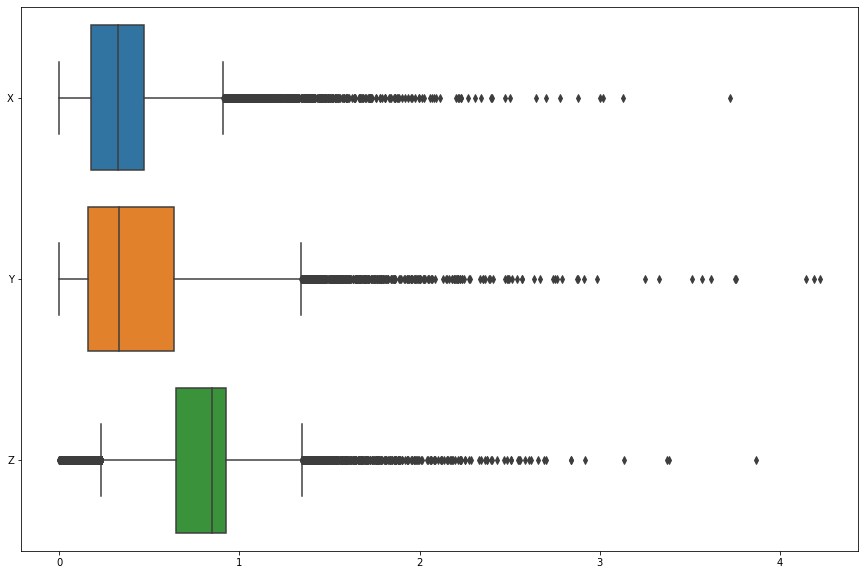

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax = sns.boxplot(data=df[['X', 'Y', 'Z']], orient='h')
display(ax)

We can note here that there are some outliers in our data sample, but they do not necessarily have to be measurement errors, as the numbers are not too large to be able to conclude this. These outliers may be due to some physical activity of the user or a sudden movement of the hand. Later on we will conclude whether this data is of value or not, as we will correlate it with the heart rate.

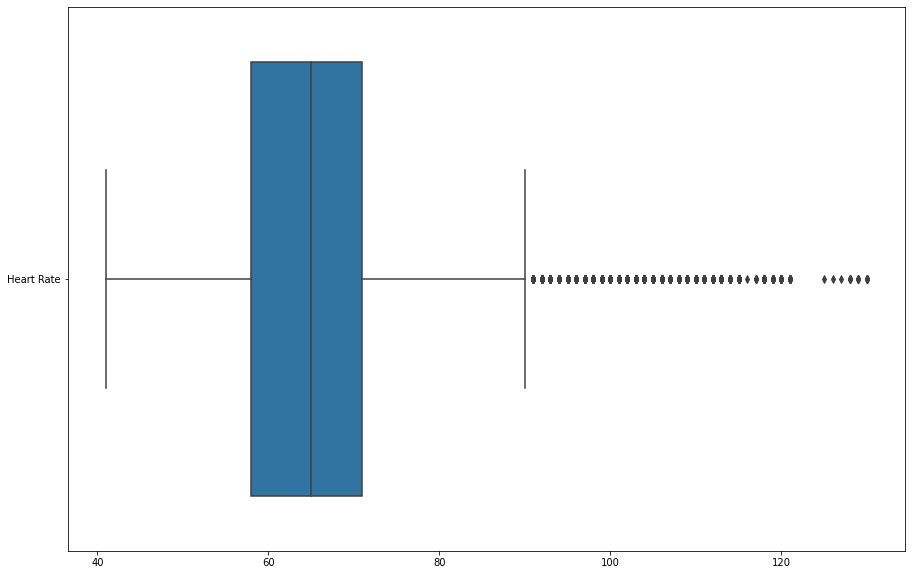

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.boxplot(data=df[['Heart Rate']],orient='h')
display(ax)

From the heart rate data samples, we can see there are some outliers above 120 bpm. According to the [American Heart Association](https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates#.WmeyWKinGUn "AHA"), a healthy resting heart rate would be approximately 60–100 bpm for most adults. These outliers are not extraordinarily disproportionate as these might be due to medication, stress, anxiety, hormones and average physical activity of the user.

#### Plotting pairwise relationships

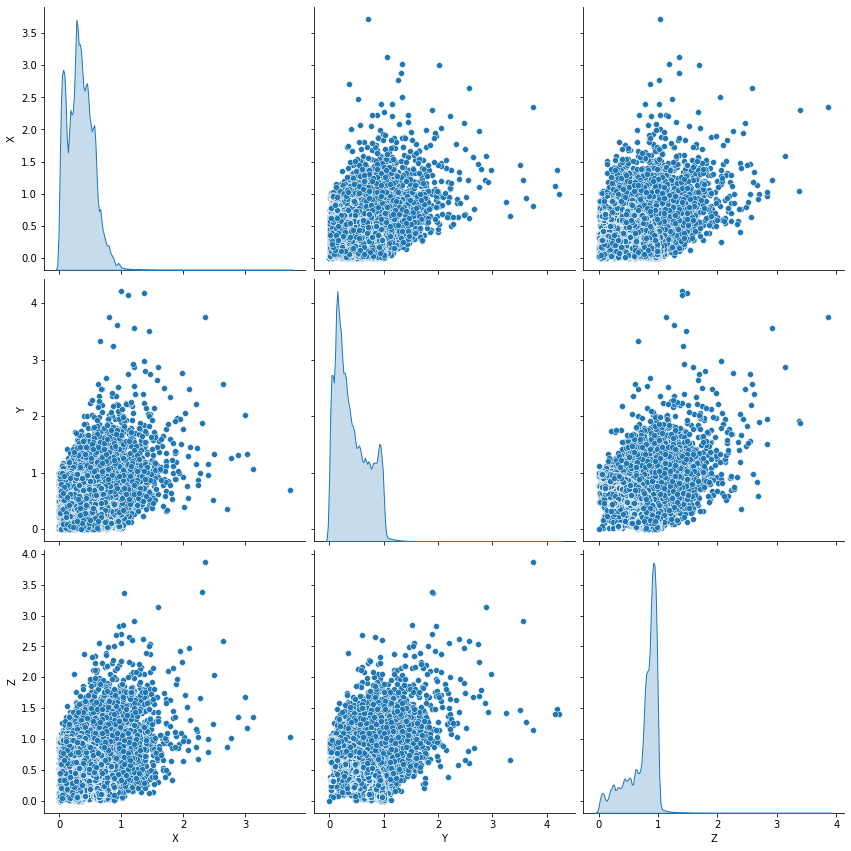

In [ ]:
sns.pairplot(df[['X', 'Y', 'Z']], kind="scatter", diag_kind= 'kde', height=4)

## Data processing

After exploring how the dataset is distributed, we then proceed to process our data and add some meaningful derived features. It is worth noting at this point, that we have tried several approaches to extract the best features for our dataset. We have used some open source libraries to help us extract these features, such as [AutoFeat](https://arxiv.org/abs/1901.07329), [TsFresh](https://tsfresh.readthedocs.io/) and [FeatureTools](https://www.featuretools.com/). Each of which has delivered different results to our dataset. After thorough heuristic experiments we concluded with the additional features shown in the snippet of code below, which have provided us the best training results to the neural network. 

**Important note**: due to time constraints for the deadline competition, we could not spend as much time as we wished to perform more effective feature engineering. Even though the results obtained from this generated dataset are fairly acceptable — especially for a microcontroller making inferences based upon sensor data — we are perfectly aware that a more elaborate dataset would help achieve even better results. We will save this task for future work after the competition, which is listed in the [Future work](../../../README.md#Future-work) section of the project description.

In [ ]:
# Calculating the jerks of each axis and the respective moduli.
df['movement_x'] = df['X'] - df['X'].shift()
df['movement_y'] = df['Y'] - df['Y'].shift()
df['movement_z'] = df['Z'] - df['Z'].shift()
df['modulo'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**0.5
df['modulo_movement'] = (df['movement_x']**2 + df['movement_y']**2 + df['movement_z']**2)**0.5

# Adding derived Features
df['X**3'] = df['X'] **3
df['movement_x**2'] = df['movement_x']**2
df['movement_z**2'] = df['movement_z']**2
df['modulo_movement**2'] = df['modulo_movement']**2
df['exp_movement_x'] = np.exp(df['movement_x'])

df

## Autofeat (automatic feature generator)

In [ ]:
labels = df['Labels']

df_features = df.drop('Labels', axis=1).fillna(0)
target = labels

for steps in range(2):
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(df_features, target)
    r2 = afreg.score(df_features, target)
    print("## Final R^2: %.4f" % r2)
    
# Reindex Labels Column
df['Labels'] = labels

# Final processed dataset
df

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 14 features.
[AutoFeat] With 262295 data points this new feature matrix would use about 0.01 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 13 features after 5 feature selection runs
[featsel] 13 features after correlation filtering
[featsel] 0 features after noise filtering
[featsel] WARNING: Not a single good features was found...
[AutoFeat] Final dataframe with 14 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
2.0
[AutoFeat] Final score: 0.0000
## Final R^2: 0.0000
### AutoFeat with 1 feateng_steps
[AutoFeat] The 1 step feature engineering process could generate up to 

,X,Y,Z,Heart Rate,movement_x,movement_y,movement_z,modulo,modulo_movement,X**3,movement_x**2,movement_z**2,modulo_movement**2,exp_movement_x,Labels
0,0.369568,0.061432,0.922989,52.0,0.000000,0.000000,0.000000,0.996124,0.000000,0.050476,0.000000,0.000000,0.000000,0.000000,0.0
1,0.626755,0.372574,0.909332,81.0,0.257187,0.311142,-0.013657,1.165555,0.403907,0.246203,0.066145,0.000187,0.163141,1.293287,0.0
2,0.412994,0.244675,0.884964,77.0,-0.213760,-0.127899,-0.024368,1.006773,0.250291,0.070442,0.045694,0.000594,0.062646,0.807542,0.0
3,0.553223,0.156952,0.824646,65.0,0.140228,-0.087723,-0.060318,1.005351,0.176061,0.169317,0.019664,0.003638,0.030998,1.150536,0.0
4,0.670242,0.471481,0.585983,83.0,0.117020,0.314529,-0.238663,1.007420,0.411804,0.301089,0.013694,0.056960,0.169582,1.124141,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262290,0.325638,0.123169,0.947433,53.0,-0.039261,-0.051605,0.033783,1.009376,0.073115,0.034531,0.001541,0.001141,0.005346,0.961500,4.0
262291,0.338287,0.290955,0.893051,58.0,0.012650,0.167786,-0.054382,0.998315,0.176832,0.038713,0.000160,0.002957,0.031269,1.012730,4.0
262292,0.570755,0.384750,0.749130,77.0,0.232468,0.093796,-0.143921,1.017345,0.289054,0.185930,0.054041,0.020713,0.083552,1.261710,4.0
262293,0.020538,0.721848,0.703278,72.0,-0.550217,0.337097,-0.045853,1.008010,0.646897,0.000009,0.302738,0.002102,0.418475,0.576825,4.0


## Normalizing dataset

Last step to get the data ready to be fed into an ML model is normalization. This will modify the different features to a common scale, helping gradients reduce large back-and-forth oscillation steps in the learning process.

Each feature in our dataset offers different ranges, with heart rate being the most notable. After some experiments, we found that the best learning results were obtained with **all the features normalized** within their respective ranges.

However, it is important to note that this process may vary from dataset to dataset and this approach could be different. 

<ins>Side note:</ins> if the model is trained with normalized data, it is important that we follow the same process in the microcontroller unit (MCU) when making inferences from the data measured by the sensors. It is therefore crucial to save the normalization ranges of each feature to later apply them in the device.

In [ ]:
# Directory to store files containing essential information necessary for the the Arduino sketch.
mcu_dir = 'mcu'

if not os.path.exists(mcu_dir):
    os.mkdir(mcu_dir)

norm_ranges_filename = os.path.join(mcu_dir, "normalization_ranges.txt")

# Storing ranges in a C-style format to write it in file
norm_rang_text = "const float normalization_ranges[features*2]{\n\t"

# Normalizing all features
for count, feature_name in enumerate(df.loc[:, df.columns != 'Labels']):
    
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()

    # Appending the values in standard notation and with 6 decimals
    norm_rang_text += str("%.6f" % min_value) + ", " + str("%.6f" % max_value) + ",\n\t"

    # Apply normalization to column and round to 4 decimals
    df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)

    df[feature_name] = df[feature_name].round(4)

norm_rang_text = norm_rang_text[:-3]
norm_rang_text += "\n};"

# Save normalization ranges into file
with open(norm_ranges_filename, "w") as file:
    file.write(norm_rang_text)
    
# Save the final processed dataset
df.to_csv("dataset.csv")

df

,X,Y,Z,Heart Rate,movement_x,movement_y,movement_z,modulo,modulo_movement,X**3,movement_x**2,movement_z**2,modulo_movement**2,exp_movement_x,Labels
0,0.0991,0.0143,0.2385,0.1236,0.4553,0.5133,0.5076,0.0018,0.0000,0.0010,0.0000,0.0000,0.0000,0.0000,0.0
1,0.1682,0.0880,0.2350,0.4494,0.4943,0.5521,0.5053,0.0365,0.0792,0.0048,0.0051,0.0000,0.0063,0.0356,0.0
2,0.1107,0.0577,0.2287,0.4045,0.4230,0.4973,0.5035,0.0040,0.0491,0.0014,0.0035,0.0001,0.0024,0.0222,0.0
3,0.1484,0.0369,0.2131,0.2697,0.4766,0.5023,0.4975,0.0037,0.0345,0.0033,0.0015,0.0004,0.0012,0.0316,0.0
4,0.1799,0.1114,0.1514,0.4719,0.4731,0.5525,0.4678,0.0041,0.0807,0.0058,0.0011,0.0062,0.0065,0.0309,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262290,0.0873,0.0289,0.2449,0.1348,0.4494,0.5069,0.5132,0.0045,0.0143,0.0007,0.0001,0.0001,0.0002,0.0264,4.0
262291,0.0907,0.0686,0.2308,0.1910,0.4573,0.5342,0.4985,0.0023,0.0347,0.0008,0.0000,0.0003,0.0012,0.0278,4.0
262292,0.1532,0.0909,0.1936,0.4045,0.4906,0.5250,0.4836,0.0062,0.0566,0.0036,0.0042,0.0022,0.0032,0.0347,4.0
262293,0.0053,0.1707,0.1817,0.3483,0.3720,0.5553,0.4999,0.0042,0.1268,0.0000,0.0234,0.0002,0.0161,0.0159,4.0


## Splitting the dataset

We will use a (70%, 20%, 10%) split for the training, validation, and test sets, respectively. Note that the data is not being randomly shuffled before splitting. This is for two reasons:

* It ensures that chopping the data into windows of consecutive samples is still possible.
* It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
def split_dataset(df, percentage_train, percentage_val, seed=42):

    assert percentage_train + percentage_val < 1, 'Percentage given to split not correct'

    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    total_rows = len(df.index)

    train_end = int(percentage_train * total_rows)
    validate_end = int(percentage_val * total_rows) + train_end

    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]

    return train, validate, test

In [ ]:
train_df, val_df, test_df = split_dataset(df, 0.7, 0.2)

assert len(train_df) + len(val_df) + len(test_df) == df.shape[0], 'The split does not match'

## Reshaping data into segments and prepare for Keras

The dataframe is not ready to be fed into a neural network yet. Therefore, we need to modify it into an adequate shape.

In [ ]:
def create_segments_and_labels(dataframe):

    labels = dataframe.iloc[:,-1:]
    segments = dataframe.iloc[:,:-1]

    return segments, labels

In [ ]:
x_train, y_train = create_segments_and_labels(train_df)
x_val, y_val = create_segments_and_labels(val_df)
x_test, y_test = create_segments_and_labels(test_df)

assert x_train.shape[0] == len(y_train)
assert x_val.shape[0] == len(y_val)
assert x_test.shape[0] == len(y_test)

In [ ]:
# Preparing labels data (Needed ONLY for categorical_crossentropy loss function)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)  

# Building the model

For this project, we have decided to create a Deep Neural Network Model using the Keras API, which allows us an easy conversion later to a suitable format for running in microcontrollers.

While very wide shallow networks are very good at memorization, multiple-layer networks are much better at generalizing, since they learn all the intermediate features. Having this in mind, for our model architecture we have taken an intermediate approach between both extremes, which we think can work better for this type of application.

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_dim=x_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 19,493
Trainable params: 19,493
Non-trainable params: 0
____________________________________________________

## Creating callbacks

* Early stopping for preventing the model from training for too long and potentially overfitting.
* TensorBoard for tracking the model progress.



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)

In [ ]:
%load_ext tensorboard

log_path = "/content/"
log_folder = "log"

log_dir = os.path.join(log_path, log_folder)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_dir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y-%m-%d, %H:%M"))

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
%tensorboard --logdir /content/log

# Training the model and evaluating results

In [ ]:
NUM_EPOCHS = 1000 #@param {type:"slider", min:10, max:1000, step:10}

In [ ]:
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val), 
    epochs=NUM_EPOCHS, 
    batch_size=180, 
    verbose=1, 
    callbacks=[tensorboard, early_stopping]
)

## Evaluating on test data

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

820/820 [==============================] - 1s 1ms/step - loss: 0.5275 - accuracy: 0.8030
Test accuracy 0.8029736876487732
Test loss 0.5275435447692871


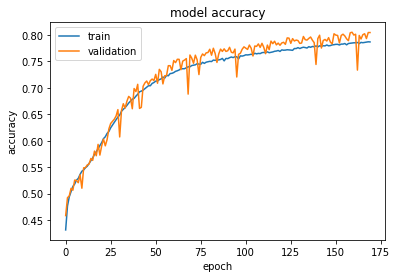

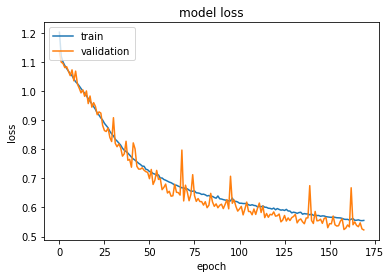

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Confusion Matrix

In [ ]:
predictions = history.model.predict(x_test)

In [ ]:
guess = 0

to_predict = len(y_test)

for index in range(to_predict):
    if np.argmax(predictions[index]) == np.argmax(y_test[index]):
        guess += 1

print("Guessed: {:.2f}%".format(guess/to_predict*100))

Guessed: 80.30%


In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

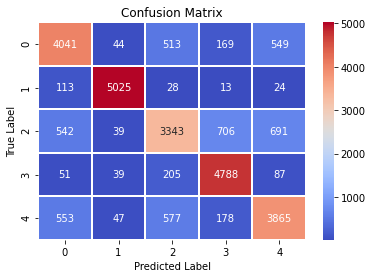

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5316
           1       0.97      0.97      0.97      5203
           2       0.72      0.63      0.67      5321
           3       0.82      0.93      0.87      5170
           4       0.74      0.74      0.74      5220

    accuracy                           0.80     26230
   macro avg       0.80      0.80      0.80     26230
weighted avg       0.80      0.80      0.80     26230



In [ ]:
y_pred_test = model.predict(x_test)

max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# Model conversion

As illustrated in the confusion matrix, the results obtained appear to be sufficiently convincing for deployment and see how well it performs on the microcontroller. 

## Generate TensorFlow Lite Model

In [ ]:
# Prepare name files for saving models
models_dir = 'models'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

saved_model_filename = os.path.join(models_dir, "tf_model")

tflite_models_dir = os.path.join(models_dir, "tflite")
if not os.path.exists(tflite_models_dir):
    os.mkdir(tflite_models_dir)

tflite_micro_models_dir = os.path.join(models_dir, "tflite_micro")
if not os.path.exists(tflite_micro_models_dir):
    os.mkdir(tflite_micro_models_dir)

float_32_tfl_model_filename = os.path.join(tflite_models_dir, "float_32.tfl")
float_16_tfl_model_filename = os.path.join(tflite_models_dir, "float_16.tfl")
quantized_no_aware_tfl_model_filename = os.path.join(tflite_models_dir, "quantized_no_aware.tfl")
tfl_cc_model_filename = os.path.join(tflite_micro_models_dir, "model.cc")

# Save the trained model
model.save(saved_model_filename)

## Post-training quantization

The accuracy attained by the model is fairly decent and fulfils the requirements set at the beginning of the project (~80%). Although there is still room for experimentation to perform more Hyperparameter Tuning to enhance the overall model metrics, it is fair to say that the model seems to be ready for deployment in order to carry out some real-life tests. 

As a first step, let's apply post-training quantization (PTQ) which can easily give us a first sight of how well we can shrink the model down, gaining an improvement in size and latency reduction at the cost of some accuracy loss.

If after PTQ the drop in accuracy is not within acceptable limits, we will explore other techniques to help the model *recover* its accuracy.

In [ ]:
def convert_and_save_model(original_model_filename, output_filename, 
                           optimize=False, integer_only=False):

    converter = tf.lite.TFLiteConverter.from_saved_model(original_model_filename)

    if optimize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]

        if integer_only:
            converter.inference_input_type = tf.int8
            converter.inference_output_type = tf.int8
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
       
            DATA_SAMPLE_SIZE = 100

            # Small chunk of dataset for model input, activations and model output calibration
            def representative_data_gen():
                df_sample = np.array(df.sample(DATA_SAMPLE_SIZE), dtype=np.float32)

                for row in range(DATA_SAMPLE_SIZE):
                    ret = df_sample[row][:-1]  # take all the columns except for labels
                    yield [ret.reshape(1, ret.shape[0])]  # the input must be 1 


            converter.representative_dataset = representative_data_gen

        else:
            # It reduces model size by up to half, causing minimal loss in accuracy at the cost of not reduction in latency
            converter.target_spec.supported_types = [tf.float16]
            

    model_tflite = converter.convert()

    # Save the model to disk
    open(output_filename, "wb").write(model_tflite)

In [ ]:
convert_and_save_model(saved_model_filename, float_32_tfl_model_filename)
convert_and_save_model(saved_model_filename, quantized_no_aware_tfl_model_filename, optimize=True, integer_only=True)
convert_and_save_model(saved_model_filename, float_16_tfl_model_filename, optimize=True)

The generated `quantized model` depicts a **x4** times reduction in size compared to the `float model` (orginial version).

So far so good. Let's see how much the penalty has been for the accuracy metric.

### Testing the accuracy after Quantization

Verify that the model we have exported is still accurate, using the TF Lite Python API and our test set.

In [ ]:
# Helper function to run inference
def run_tflite_inference_test(tflite_model_path, model_type="Float", verbose=True):
    
    # --- Load test data    
    SAMPLES = 10000
    test_data = np.array(test_df.sample(SAMPLES)).reshape(SAMPLES, test_df.shape[1])
    
    test_samples = np.zeros((SAMPLES, test_data.shape[1]-1), dtype=np.float32)
    test_labels = np.zeros((SAMPLES, 1), dtype=np.float32)
    
    for row in range(SAMPLES):
        test_labels[row] = test_data[row][-1:]
        test_samples[row] = test_data[row][:-1]

    test_samples = np.expand_dims(test_samples, axis=1).astype(np.float32)
    
    # --- Initialize the interpreter
    interpreter = tf.lite.Interpreter(tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    
    # --- For quantized models, manually quantize the input data from float to integer    
    if model_type == "Quantized":
        input_scale, input_zero_point = input_details["quantization"]
        test_samples = test_samples / input_scale + input_zero_point
        test_samples = test_samples.astype(input_details["dtype"])

    
    # --- Evaluate the predictions    
    correct_predictions = 0
    for i in range(len(test_samples)):
        interpreter.set_tensor(input_details["index"], test_samples[i])
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        top_prediction = output.argmax()
        correct_predictions += (top_prediction == test_labels[i])

    acc = ((correct_predictions * 100) / len(test_samples))[0]
    
    if verbose:
        print(f'{model_type} model accuracy is {acc:.2f} % after {len(test_samples)} test samples')

    return acc

In [ ]:
# Compute float model accuracy
run_tflite_inference_test(float_32_tfl_model_filename)

# Compute quantized model accuracy
run_tflite_inference_test(quantized_no_aware_tfl_model_filename, model_type='Quantized')

# Compute quantized model accuracy
run_tflite_inference_test(float_16_tfl_model_filename)

Float model accuracy is 80.69 % after 10000 test samples
Quantized model accuracy is 47.57 % after 10000 test samples
Float model accuracy is 80.28 % after 10000 test samples


80.28

We can see the quantized model has decreased accuracy significantly. Let's display these results more neatly in a comparative table.

In [ ]:
def draw_comparative_table(*models_to_compare):

    model_name = []
    model_size = []
    model_acc = []
    rows = []

    for i, model in enumerate(models_to_compare):

        model_name.append(os.path.basename(model))
        model_size.append(os.path.getsize(model))

        model_type = 'Quantized' if model_name[i].startswith('q') else 'Float'
        
        model_acc.append(run_tflite_inference_test(model, model_type=model_type, verbose=False))


    for model in range(len(models_to_compare)):
        rows.append(
            [model_name[model], f"{model_size[model]} bytes", f'{model_acc[model]} %']
        )
    
    return pd.DataFrame.from_records(rows, columns = ["Model", "Size", "Accuracy"])

In [ ]:
draw_comparative_table(
    float_32_tfl_model_filename, 
    quantized_no_aware_tfl_model_filename, 
    float_16_tfl_model_filename
)

,Model,Size,Accuracy
0,float_32.tfl,80532 bytes,79.95 %
1,quantized_no_aware.tfl,23400 bytes,46.87 %
2,float_16.tfl,42768 bytes,80.58 %


There are some key points to note here from these results. 

The size reduction for both optimized models is not far from what was expected: **x4** times for the fully quantized model (conversion from 32 to 8 bits) and **x2** times for the 16-bit floating point model (conversion from 32 to 16 bits).

Conversely, the accuracy results show some notable changes. While the 16-bit model keeps the accuracy high, the fully quantized model shows an undesirable drop in accuracy.

At this point, it is worth trying to shrink the model's size as much as we can, since the x4 reduction of the full quantized model is still appealing. If reducing more does not help keeping accuracy reasonably high, we will then retain the 16 bit model.

## Applying Quantization Aware Training

As applying only PTQ has affected negatively the model metrics, we now proceed to apply Quantization Aware Training (QAT). This will require making a copy of the original model's structure and training it again but emulating inference-time quantization beforehand. This will raise the RNN's awareness of an upcoming quantization after training.

In [ ]:
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

In [ ]:
q_aware_model = tf.keras.models.clone_model(model)

q_aware_model = tfmot.quantization.keras.quantize_model(q_aware_model)

q_aware_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 14)                3         
_________________________________________________________________
quant_dense (QuantizeWrapper (None, 32)                485       
_________________________________________________________________
quant_dense_1 (QuantizeWrapp (None, 64)                2117      
_________________________________________________________________
quant_dense_2 (QuantizeWrapp (None, 128)               8325      
_________________________________________________________________
quant_dense_3 (QuantizeWrapp (None, 64)                8261      
_________________________________________________________________
quant_dropout (QuantizeWrapp (None, 64)                1         
_________________________________________________________________
quant_dense_4 (QuantizeWrapp (None, 5)                 3

In [ ]:
q_aware_model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val), 
    epochs=NUM_EPOCHS, 
    batch_size=180, 
    verbose=1, 
    callbacks=[early_stopping]
)

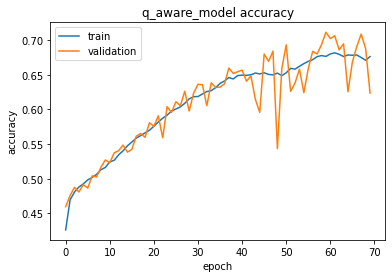

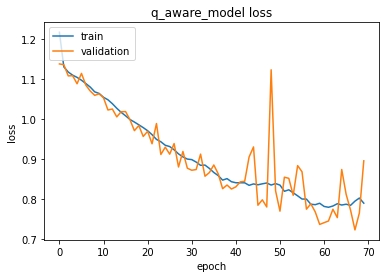

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('q_aware_model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('q_aware_model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
saved_aware_model_filename = os.path.join(models_dir, "tf_aware_model")
q_aware_model.save(saved_aware_model_filename)

quantized_tfl_model_filename = os.path.join(tflite_models_dir, "quantized.tfl")
convert_and_save_model(saved_aware_model_filename, quantized_tfl_model_filename, optimize=True, integer_only=True)

run_tflite_inference_test(quantized_tfl_model_filename, model_type='Quantized')

INFO:tensorflow:Assets written to: models/tf_aware_model/assets


INFO:tensorflow:Assets written to: models/tf_aware_model/assets


Quantized model accuracy is 65.17 % after 10000 test samples


65.17

As we can see, QAT has helped make the model resilient before applying post-training quantization. This accuracy looks very promising for a model x4 times smaller than the original one.

## Model comparison
Displaying all the created models thus far for comparison between size and accuracy.

In [ ]:
draw_comparative_table(
    float_32_tfl_model_filename, 
    float_16_tfl_model_filename, 
    quantized_no_aware_tfl_model_filename, 
    quantized_tfl_model_filename)

,Model,Size,Accuracy
0,float_32.tfl,80532 bytes,80.81 %
1,float_16.tfl,42768 bytes,80.23 %
2,quantized_no_aware.tfl,23400 bytes,47.58 %
3,quantized.tfl,23816 bytes,65.88 %


Taking this into account, we can assure that QAT proves to be an essential component for our model, contributing to a significant increase in accuracy while keeping its size tiny.

The model then is ready to be deployed into a microcontroller and start making inferences!

## Generate TensorFlow Lite for Microcontrollers Model
Using the ```xxd``` tool to convert the ```.tflite``` TensorFlow Lite quantized model into a ```.cc``` C source file, that can be loaded by TensorFlow Lite for Microcontrollers on the Arduino.

In [ ]:
!apt-get update && apt-get -qq install xxd

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {quantized_tfl_model_filename} > {tfl_cc_model_filename}

# Update variable names
REPLACE_TEXT = quantized_tfl_model_filename.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/smart_alarm_model/g' {tfl_cc_model_filename}

In [ ]:
# save all models created in a zip
!zip -r models.zip ./models/

In [ ]:
# Save the C source file in mcu directory to include in Arduino sketch
!cat {tfl_cc_model_filename} > ./mcu/smart_alarm_model.txt

###### Generate samples for microcontroller

The following cell only needs to be run for test purposes in the microcontroller.

Extracting a random number of samples from the dataset in a C++ syntax-format to test how well the model infers once deployed in the microcontroller. The generated file is meant to be used in the `test_smart_alarm.ino`. 

For more information about this file and where it is used, refer to the corresponding [directory](https://github.com/cargilgar/Smart-Alarm-using-tinyML/tree/main/src/arduino/test_smart_alarm).

In [ ]:
# The saved test file (data_samples.txt) should be copied to data_sample.h array. 

DATA_SAMPLE_SIZE = 1000

df_sample = np.array(df.sample(DATA_SAMPLE_SIZE), dtype=np.float32)

data_samples_filename = os.path.join(mcu_dir, 'data_samples.txt')

with open(data_samples_filename, 'w') as file:

    columns_header = "/* " + str(df.columns) + " */\n\n"
    file.write(columns_header)

    text = "float samples[number_of_samples]{\n\t"

    for row in range(DATA_SAMPLE_SIZE):
        ret = df_sample[row]

        for column in range(ret.shape[0]-1):
            
            # Convert it to string in standard notation (not scientific) and with 4 decimals.            
            text += str("%.4f" % ret[column]) + ", "

        else:
            # Append label without decimals
            string_value = str(ret[14])           
            text += string_value[:-2] + ",\n\t"

    text = text[:-3]

    text += "\n};\n\n uint32_t number_of_samples = " + str(DATA_SAMPLE_SIZE*df.shape[1]) + ";"

    file.write(text)


# Or print it in the output cell if you wish, by uncommenting this line below.    
# !cat ./mcu/data_samples.txt